# 🎨 Neural Style Transfer  
Undergraduate Project (Sem-6)

---

**Author - Siddharth Gautam**  
Roll No: 22124043

Department of Mathematical Sciences  
Indian Institute of Technology (IIT) BHU, Varanasi  








## 📚 1. Libraries and Setup

We import essential PyTorch modules, pre-trained VGG19 from `torchvision.models`, and utilities like PIL and matplotlib for image handling and visualization.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

# --- Load VGG19 model ---
import torchvision.models as models
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = models.vgg19(pretrained=True).features.to(device).eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 89.2MB/s]


## 🖼️ 2. Load and Preprocess Images

We load the content and style images, apply resizing and transformation to tensors, and transfer them to the computation device.


In [ ]:
def image_loader(image_name, target_size=None):
    image = Image.open(image_name).convert("RGB")
    if target_size:
        image = image.resize(target_size, Image.LANCZOS)
    transform = transforms.ToTensor()
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

content_path = "/content/INPUT.jpeg"
style_path = "/content/STYLE.webp"

content_img = image_loader(content_path)
style_img = image_loader(style_path, (content_img.shape[-1], content_img.shape[-2]))

assert content_img.size() == style_img.size(), "Style and content images must be the same size!"


## 🖼️ 3. Display Content and Style Images


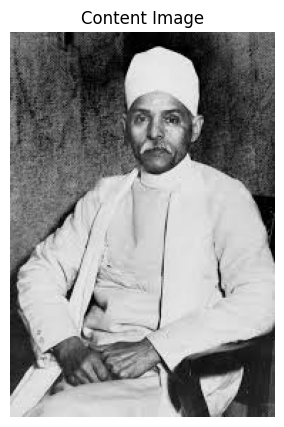

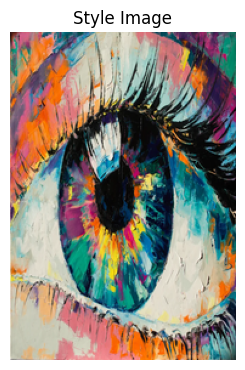

In [ ]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Show content and style images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(content_img, title="Content Image")
plt.subplot(1, 2, 2)
imshow(style_img, title="Style Image")


## 🔧 4. Define Content & Style Loss Functions
We define `ContentLoss`, `StyleLoss`, and a `gram_matrix` function to measure feature similarity and style representation.


In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    return torch.mm(features, features.t()) / (c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target, weight=1.0):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target).detach()
        self.weight = weight

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = self.weight * nn.functional.mse_loss(G, self.target)
        return input


## 📏 5. Normalization Layer

This layer is used to normalize input images using ImageNet statistics, matching the training conditions of VGG19.


In [ ]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std


## 🧠 6. Build the Style Transfer Model

We extract features from intermediate VGG19 layers and attach loss modules to compute content and style losses.


In [ ]:
content_layers = ["conv_4"] #bcz i want to extract higher dfn features for content
style_layers = {
    "conv_1": 1.0,
    "conv_2": 0.75,
    "conv_3": 0.2,
    "conv_4": 0.2,
    "conv_5": 0.2,
}
#bcz we extract primitive features for style => texture,gradient patterns ,etc

def get_model_and_losses(cnn, style_img, content_img):
    normalization = Normalization([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    content_losses, style_losses = [], []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            weight = style_layers[name]
            style_loss = StyleLoss(target, weight)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim after last loss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[: i + 1]

    return model, content_losses, style_losses


## 🌀 7. Run Style Transfer

We optimize the input image to match content from the content image and style from the style image.


Iteration 400: Style Loss 0.0001, Content Loss 3.1772
Iteration 800: Style Loss 0.0000, Content Loss 3.3369
Iteration 1200: Style Loss 0.0000, Content Loss 3.4477
Iteration 1600: Style Loss 0.0000, Content Loss 3.5357
Iteration 2000: Style Loss 0.0000, Content Loss 3.6098


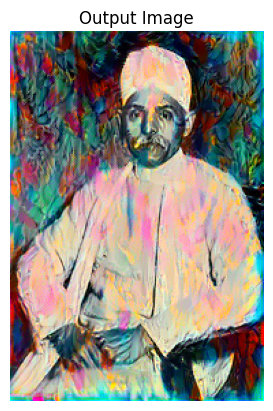

In [ ]:
# Style Transfer Process:
# 1. Build model with content & style loss layers.
# 2. Clone content_img as input to optimize.
# 3. Set up Adam optimizer on input_img.
# 4. For each step:
#    - Clamp image values to [0, 1]
#    - Zero gradients, run model
#    - Compute style & content losses
#    - Combine, backpropagate, print every 400 steps
# 5. optimizer.step(closure) updates input_img
# 6. Repeat until num_steps reached
# 7. Final clamp and return stylized image


def run_style_transfer(cnn, content_img, style_img, num_steps=2000,
                       style_weight=1e9, content_weight=1):
    model, content_losses, style_losses = get_model_and_losses(cnn, style_img, content_img)
    #research ppr said to clone , it is one of the ways though.
    input_img = content_img.clone()
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.003)

    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)
            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            run[0] += 1
            if run[0] % 400 == 0:
                print(f"Iteration {run[0]}: Style Loss {style_score.item():.4f}, Content Loss {content_score.item()/10:.4f}")
            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

output = run_style_transfer(cnn, content_img, style_img)
imshow(output, title="Output Image")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image loader
def image_loader(image_name, target_size=None):
    image = Image.open(image_name).convert("RGB")
    if target_size:
        image = image.resize(target_size, Image.LANCZOS)
    transform = transforms.ToTensor()
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

# Load images
content_path = "/content/img6.png"
style_path = "/content/img5.png"
content_img = image_loader(content_path)
style_img = image_loader(style_path, (content_img.shape[-1], content_img.shape[-2]))

assert content_img.size() == style_img.size(), "Style and content images must be the same size!"

# Display function
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Display input images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(content_img, title="Content Image")
plt.subplot(1, 2, 2)
imshow(style_img, title="Style Image")

# Load VGG19 model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Loss modules
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    return torch.mm(features, features.t()) / (c * h * w)

class StyleLoss(nn.Module):
    def __init__(self, target, weight=1.0):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target).detach()
        self.weight = weight

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = self.weight * nn.functional.mse_loss(G, self.target)
        return input

# Normalization
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

# Layer weights
content_layers = ["conv_4"]
style_layers = {
    "conv_1": 1.0,
    "conv_2": 0.75,
    "conv_3": 0.2,
    "conv_4": 0.2,
    "conv_5": 0.2,
}

# Model constructor
def get_model_and_losses(cnn, style_img, content_img):
    normalization = Normalization([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    content_losses, style_losses = [], []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_img).detach()
            weight = style_layers[name]
            style_loss = StyleLoss(target, weight)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # Trim model after the last loss layer
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[: i + 1]

    return model, content_losses, style_losses

# Style transfer function
def run_style_transfer(cnn, content_img, style_img, num_steps=2000,
                       style_weight=1e9, content_weight=1):
    model, content_losses, style_losses = get_model_and_losses(cnn, style_img, content_img)
    input_img = content_img.clone()
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.003)

    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)

            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            run[0] += 1
            if run[0] % 400 == 0:
                print(f"Iteration {run[0]}: Style Loss {style_score.item():.4f} Content Loss {content_score.item():.4f}")

            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

# Run and show result
output = run_style_transfer(cnn, content_img, style_img)
imshow(output, title="Output Image")


FileNotFoundError: [Errno 2] No such file or directory: '/content/img6.png'